<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/COVID19-PPE-Object-Detection-yolov5/Kaggle_COVID_19_PPE_Dataset_Inference_(yolo_v5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Ultralytics Yolov5 설치

In [1]:
# Clone and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 10912, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10912 (delta 2), reused 10 (delta 2), pack-reused 10901
Receiving objects: 100% (10912/10912), 11.03 MiB | 26.65 MiB/s, done.
Resolving deltas: 100% (7535/7535), done.
/content/yolov5
     |████████████████████████████████| 596 kB 7.2 MB/s 
/content


#2. 데이터 다운로드

In [2]:
import glob
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [4]:
!kaggle datasets download -d ialimustufa/object-detection-for-ppe-covid19-dataset

 97% 120M/123M [00:00<00:00, 102MB/s] 
100% 123M/123M [00:01<00:00, 127MB/s]


In [ ]:
!unzip '*.zip'

In [6]:
!mkdir covid
!mkdir covid/images; mkdir covid/labels
!mkdir covid/images/train; mkdir covid/images/val
!mkdir covid/labels/train; mkdir covid/labels/val

In [10]:
CLASS_NAMES = []

In [7]:
def xml_to_txt(input_xml_file, output_txt_file):
  # ElementTree로 입력 XML파일 파싱
  tree = ET.parse(input_xml_file)
  root = tree.getroot()
  img_node = root.find('size')
  # 만약 img_node를 찾지 못하면 해당 xml파일을 변환 종료
  if img_node is None:
    return None

  # 원본 이미지의 너비와 높이 추출.
  img_width = int(img_node.find('width').text)
  img_height = int(img_node.find('height').text)

  # 만약 너비와 높이 값이 0이라면 이미지 파일을 읽어서 너비와 높이를 구함
  if img_width == 0 or img_height == 0:
    img_path = input_xml_file.replace('.xml', '.jpg')
    if cv2.imread(img_path) is None:
      img_height, img_width = cv2.imread(img_path.replace('.jpg', '.png')).shape[:2]
    else:
      img_height, img_width = cv2.imread(img_path).shape[:2]
  
  # xml 파일내에 있는 모든 object Element를 찾는다.
  with open(output_txt_file, 'w') as output_fpointer:
    for obj in root.findall('object'):
      # bndbox를 찾아서 좌상단(x1, y1), 우하단(x2, y2) 좌표 추출.
      xmlbox = obj.find('bndbox')
      x1 = int(xmlbox.find('xmin').text)
      y1 = int(xmlbox.find('ymin').text)
      x2 = int(xmlbox.find('xmax').text)
      y2 = int(xmlbox.find('ymax').text)

      object_name = obj.find('name').text

      # 만약 좌표중에 0보다 작은 값이 있으면 해당 xml파일 변환 종료
      if (x1 < 0) or (y1 < 0) or (x2 < 0) or (y2 < 0):
        break
      
      # object_name 원본 좌표를 입력하여 Yolo 포맷으로 변환하는 함수 호출
      class_id, cx_norm, cy_norm, bbw_norm, bbh_norm = convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2)

      #변환된 yolo 좌표를 object별로 출력 text 파일에 write
      value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, bbw_norm, bbh_norm)
      output_fpointer.write(value_str + '\n')

def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출.
  if object_name not in CLASS_NAMES:
    CLASS_NAMES.append(object_name)
  class_id = CLASS_NAMES.index(object_name)
  # 중심 좌표와 너비, 높이 계산. 
  center_x = (x1 + x2)/2
  center_y = (y1 + y2)/2
  width = x2 - x1
  height = y2 - y1
  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width
  height_norm = height / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)

In [11]:
import shutil

def make_yolo_annot_file(src_dir, dst_dir):
  src_imgs = glob.glob(src_dir + '/*.jpg')
  src_imgs.extend(glob.glob(src_dir + '/*.png'))
  src_imgs.extend(glob.glob(src_dir + '/*.jpeg'))
  src_annots = glob.glob(src_dir + '/*.xml')

  if 'train' in src_dir:
    dst_img_dir = os.path.join(dst_dir, 'images/train')
    dst_annot_dir = dst_img_dir.replace('images', 'labels')
  else:
    dst_img_dir = os.path.join(dst_dir, 'images/val')
    dst_annot_dir = dst_img_dir.replace('images', 'labels')

  for img in src_imgs:
    shutil.copy(img, os.path.join(dst_img_dir,img.split('/')[-1]))
  
  for annot in src_annots:
    xml_to_txt(annot, os.path.join(dst_annot_dir, annot.split('/')[-1].replace('.xml', '.txt')))

# train용 images와 label annotation 생성
make_yolo_annot_file('/content/dataset/train', '/content/covid')
# validation용 images와 label annotation 생성
make_yolo_annot_file('/content/dataset/test', '/content/covid')

#3. Validation 데이터 Inference 수행

In [12]:
!mkdir detect_output

In [13]:
!python yolov5/detect.py --weights '/content/drive/MyDrive/covidPPE/covid/weights/best.pt' \
--conf 0.25 --source /content/covid/images/val --project detect_output

detect: weights=['/content/drive/MyDrive/covidPPE/covid/weights/best.pt'], source=/content/covid/images/val, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=detect_output, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-270-g0365379 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/50 /content/covid/images/val/3y46u.jpg: 640x384 1 Mask, 1 Coverall, Done. (0.010s)
image 2/50 /content/covid/images/val/arht.jpg: 608x640 3 Masks, 2 Face_Shields, 2 Coveralls, Done. (0.011s)
image 3/50 /content/covid/images/val/bg.jpg: 384x640 3 Masks, 2 Coveralls, 2 Goggless, Done. (0.010s)
image 4/50 /content/cov

In [25]:
COLOR_LIST = [(255, 0, 0),
              (0, 255, 0),
              (0, 0, 255),
              (120, 255, 0),
              (0, 255, 120)]

# 이미지에 바운딩 박스를 추가하는 함수
def draw_box(img, annot):
  h, w = img.shape[:2]
  with open(annot, 'r') as f:
    for line in f:
      l = list(map(float, line.strip('\n').split(' ')))
      center_x, center_y = int(l[1] * w), int(l[2] * h)
      box_w, box_h = int(l[3] * w), int(l[4] * h)

      left = int(center_x - (box_w / 2))
      top = int(center_y - (box_h / 2))
      right = int(left + box_w)
      bottom = int(top + box_h)

      class_id = int(l[0])
      color = COLOR_LIST[class_id]
      caption = CLASS_NAMES[class_id]

      cv2.rectangle(img, (left,top), (right, bottom), color = color, thickness = 2)
      cv2.putText(img, caption, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

  return img

#Inference 결과 시각화

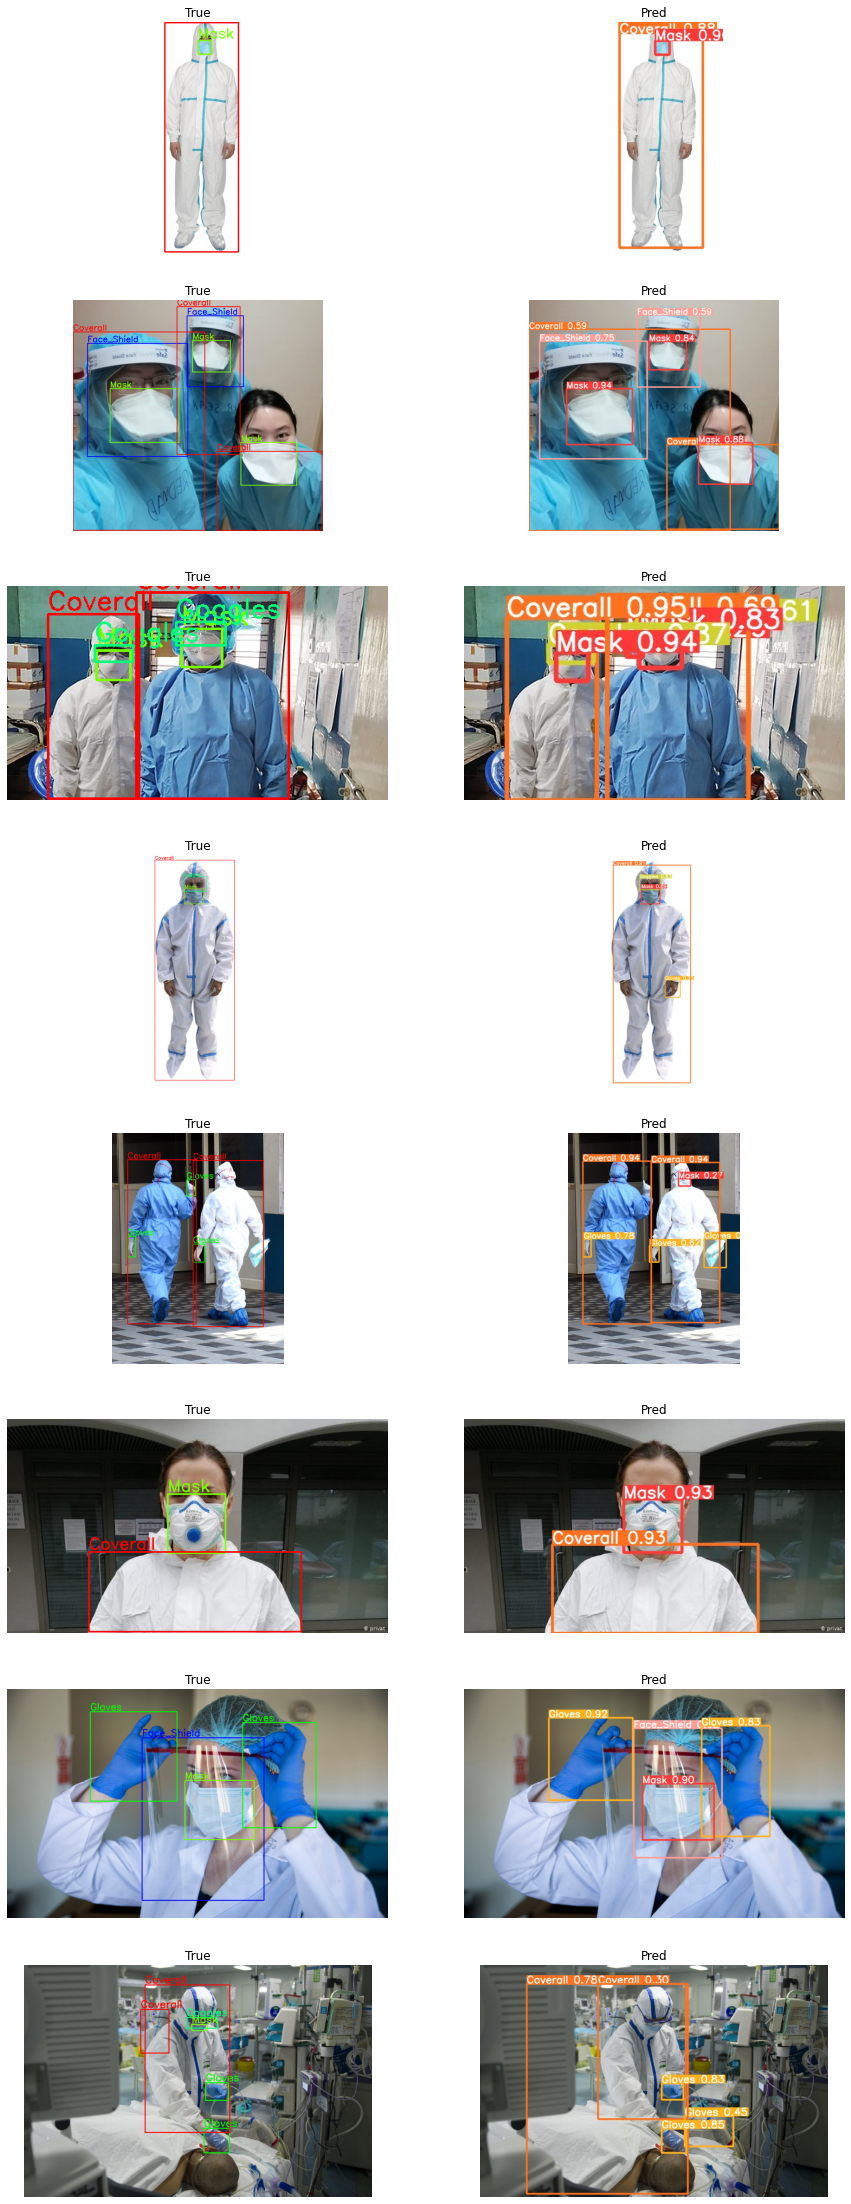

In [26]:
num_samples = 8
gt_imgs = sorted(glob.glob('/content/covid/images/val/*[jpg$|png$|jpeg]'))[:num_samples]
gt_labels = sorted(glob.glob('/content/covid/labels/val/*.txt'))[:num_samples]
pred_imgs = sorted(glob.glob('/content/detect_output/exp/*[jpg$|png$|jpeg]'))[:num_samples]

fig, ax = plt.subplots(num_samples, 2, figsize = (15, 40))

for i in range(len(gt_imgs)):
  gt_img = cv2.cvtColor(cv2.imread(gt_imgs[i]), cv2.COLOR_BGR2RGB)
  gt_bbox_img = draw_box(gt_img, gt_labels[i])
  ax[i, 0].imshow(gt_bbox_img)
  ax[i, 0].set_title('True')
  ax[i, 0].axis('off')

  pred_img = cv2.cvtColor(cv2.imread(pred_imgs[i]), cv2.COLOR_BGR2RGB)
  ax[i, 1].imshow(pred_img)
  ax[i, 1].set_title('Pred')
  ax[i, 1].axis('off')